In [17]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import station as st
import network_example as ne
import pathfinding as pf

Station 0 has 4 bikes
Station 1 has 5 bikes
Station 2 has 2 bikes
Station 3 has 4 bikes


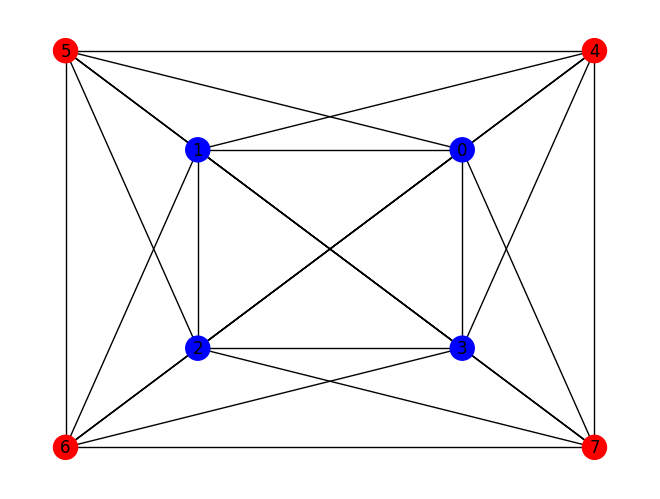

In [10]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

In [12]:
walk_multiplier = 3
# time to walk from node n1 to n2
def walk_cost(g, n1, n2):
    return g[n1][n2]['weight'] * walk_multiplier

# time to bike from node n1 to n2
def bike_cost(g, n1, n2):
    return g[n1][n2]['weight']

# find the nearest station with a bike to node n
def nearest_bike(g, n):
    # make sure there is no bike available at the current station
    if g.nodes[n]['type'] == 'station':
        assert not g.nodes[n]['data'].get_bike_availability(), 'bike should not be available at the current station for this function to be called'

    return min([i for i in g.nodes if g.nodes[i]['type'] == 'station' and g.nodes[i]['data'].get_bike_availability()], key=lambda i: g[n][i]['weight'])

# find the nearest station with a spot to park a bike to node n
def nearest_spot(g, n):
    return min([i for i in g.nodes if g.nodes[i]['type'] == 'station' and g.nodes[i]['data'].get_spot_availability()], key=lambda i: g[n][i]['weight'])

# find all stations within max_dist of node start
def all_available_bikes(g, start, max_dist):
    return [i for i in g.nodes if g.nodes[i]['type'] == 'station' and g.nodes[i]['data'].get_bike_availability() and g[start][i]['weight'] < max_dist]

def all_available_spots(g, start, max_dist):
    return [i for i in g.nodes if i != start and g.nodes[i]['type'] == 'station' and g.nodes[i]['data'].get_spot_availability() and g[start][i]['weight'] < max_dist]

# path if you are initially biking from a station to a destination
# finds the nearest spot to the destination and bikes there
def bike_std(g, start, end):
    assert g.nodes[start]['type'] == 'station', 'start must be a station'
    assert g.nodes[end]['type'] == 'destination', 'end must be a destination'
    assert start != end, 'start and end cannot be the same'
    assert g.nodes[start]['data'].get_bike_availability(), 'bike must be available at the start station'


    if nearest_spot(g, end) == start:
        return end, False, walk_cost(g, start, end)

    all_spots = all_available_spots(g, start, g[start][end]['weight'])

    if len(all_spots) == 0:
        return end, False, walk_cost(g, start, end)

    min_cost = float('inf')
    min_spot = None
    for spot in all_spots:
        cost = bike_cost(g, start, spot) + walk_cost(g, spot, end)
        if cost < min_cost:
            min_cost = cost
            min_spot = spot

    # return nearest_spot(g, end), True, bike_cost(g, start, nearest_spot(g, end)) + walk_cost(g, nearest_spot(g, end), end)
    return min_spot, True, min_cost


# path if you are initially walking to a destination
# compares the cost of walking to the destination and the cost of walking to the nearest bike and biking to the destination
def walk_d(g, start, end):
    assert g.nodes[end]['type'] == 'destination', 'end must be a destination'
    assert start != end, 'start and end cannot be the same'

    # time to walk directly to the destination
    direct_walk = walk_cost(g, start, end)

    if g.nodes[start]['type'] == 'station' and g.nodes[start]['data'].get_bike_availability():
        return end, False, direct_walk
    
    # time to walk to the nearest bike, bike to the destination
    # bike_node = nearest_bike(g, start)
    # walk_to_nearest_bike = walk_cost(g, start, bike_node)
    # bike_to_end = bike_std(g, bike_node, end)[2]
    # tot_bike_cost = walk_to_nearest_bike + bike_to_end
    min_bike_cost = float('inf')
    min_bike_node = None
    bike_nodes = all_available_bikes(g, start, g[start][end]['weight'])
    for bike_node in bike_nodes:
        walk_to_nearest_bike = walk_cost(g, start, bike_node)
        bike_to_end = bike_std(g, bike_node, end)[2]
        tot_bike_cost = walk_to_nearest_bike + bike_to_end
        if tot_bike_cost < min_bike_cost:
            min_bike_cost = tot_bike_cost
            min_bike_node = bike_node

    if direct_walk <= min_bike_cost:
        return end, False, direct_walk
    else:
        return min_bike_node, True, min_bike_cost

"""
input: graph, start node, end node, have bike boolean
output: next node, bike there boolean, time to destination
"""
def pathfind(g, start, end, bike):
    assert g.nodes[end]['type'] == 'destination', 'end must be a destination'
    assert start != end, 'start and end cannot be the same'
    
    # if we are not biking, we just walk
    if not bike:
        return walk_d(g, start, end)
    else:
        assert g.nodes[start]['type'] == 'station', 'start must be a station if we are biking'
        
        walking_time = walk_d(g, start, end)[2]
        biking_time = bike_std(g, start, end)[2]

        if walking_time <= biking_time:
            return walk_d(g, start, end)
        else:
            return bike_std(g, start, end)


Station 0 has 4 bikes
Station 1 has 5 bikes
Station 2 has 2 bikes
Station 3 has 4 bikes


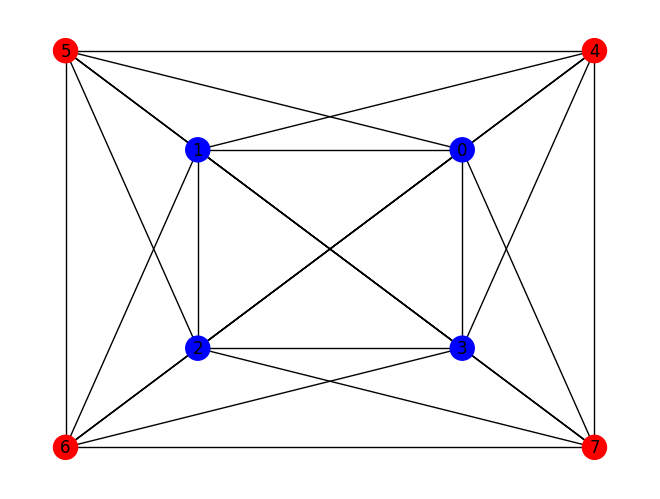

In [13]:
# draw the graph and color the stations and destinations differently
# also display the number of bikes at each station
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

In [14]:
nx.adjacency_matrix(G)[4,0]*3 + nx.adjacency_matrix(G)[0,3] + nx.adjacency_matrix(G)[3,7]*3

38.0

In [18]:
pf.pathfind(G, 4, 7, False)

(0, True, 38.0)